# **Inner Evaluation 1**

> **Evaluation of many feature extraction methods along with Random Forest**

In this part of the project we are going to search the best combination of feature extraction methods and statistics for classifying the Parkinson disease level.

We are going to apply a methodology for selecting the best alternative that is a classical approach in Machine Learning and is called inner evaluation.

The basic idea is to split the data in train an test partitions (outer), and using the training one to select the best alternative from a predictive perspective. 
This will be done using KFold Cross Validation, a robust and accurate method for estimating the predictive error of the model when predicting new data (validation data), along with grid search methods to optimize the hyper-parameters of the model. 

Along the project inner evaluation will be applied in a iterative way (in several rounds), in order to find a good enough model for our classification problem.

This is the first round of the inner evaluation and is oriented to find the features extraction methods that seem to work better for our classification task, testing all of them along with Random Forest.

We have selected Random Forest to conduct this evaluation since is a model that usually works well with any kind of tabular data, both in regression and classification problems.

## **Requirements**

In [2]:
import numpy  as np
import polars as pl
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from itertools import combinations


In [3]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyML_Package_Private')
from PyML.evaluation import SimpleEvaluation

In [4]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyAudio_Package_Private')
from PyAudio import get_X_audio_features

## **Response and Predictors definition**

In this section we define the data to be used. Specifically we define the response variable and a set of predictors matrices to be used as different alternatives, each one associate to a combination of features extraction methods and statistics.

In [5]:
files_list_name = 'Files_List.txt'
files_df = pl.read_csv(files_list_name, separator='\t', has_header=False, new_columns=['path', 'level'])

In [6]:
files_df.head(3)

path,level
str,i64
"""PDSpeechData/l…",0
"""PDSpeechData/l…",0
"""PDSpeechData/l…",0


In [7]:
files_df.shape

(240, 2)

We define the parameters to be used by the features extraction methods.

In [8]:
fs = 16000 # Sampling frequency
wst = 0.032 # Window size (seconds)
fpt = 0.008 # Frame period (seconds)
nfft = int(np.ceil(wst*fs)) # Window size (samples)
fp = int(np.ceil(fpt*fs)) # Frame period (samples)
nbands = 40 # Number of filters in the filterbank
ncomp = 20 # Number of MFCC components

In the next cell we define the response variable (target) and the different predictors matrices mentioned above.

In [9]:
Y = files_df['level'].to_numpy()

simple_methods = ['MFCC', 'spectral_centroid', 'chroma', 'spectral_bandwidth', 
                  'spectral_contrast', 'spectral_rolloff', 'zero_crossing_rate', 'tempogram']

combined_methods = []

stats = ['mean-std', 'median-std', 'mean-median-std', 'mean-Q25-median-Q75-std']

sizes = range(2, len(simple_methods) + 1)

combined_methods = ['-'.join(sorted(combi)) for size in sizes for combi in combinations(simple_methods, size)]

X_stats, X_stats_train, X_stats_test = {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}, {method: {} for method in simple_methods + combined_methods}

for method in simple_methods:
    for stat in stats:

        X_stats[method][stat] = get_X_audio_features(paths=files_df['path'], method=method, stats=stat, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp)

for method in combined_methods:
    for stat in stats:

        X_stats[method][stat] = np.column_stack([X_stats[method.split('-')[i]][stat] for i in range(0, len(method.split('-')))])

- Response variable

In [10]:
Y

array([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3],
      dtype=int64)

- `X_stats` is a dictionary with all the predictors matrices that will be considered in this round of the inner evaluation.

- There are 255 predictors matrices, that is, 255 combinations of methods-statistics. And all of them will be evaluated!

In [12]:
len(X_stats.keys())

255

- Example of the predictors matrix obtained with the method `MFCC` and the statistics `mean-std`:

In [13]:
X_stats['MFCC']['mean-std']

array([[-213.15875  ,   92.984024 ,  -64.05465  , ...,    7.095715 ,
           6.177743 ,    5.351471 ],
       [-198.98454  ,   68.04833  ,  -47.42779  , ...,    6.012935 ,
           5.59839  ,    4.8842993],
       [-240.02739  ,   59.765434 ,   -2.604349 , ...,    5.646291 ,
           5.4601407,    6.5454264],
       ...,
       [-291.60522  ,   81.844025 ,   29.577833 , ...,   13.644189 ,
          11.3029785,    9.850929 ],
       [-212.69768  ,   78.77707  ,   16.943432 , ...,    2.2818298,
           2.13314  ,    2.4295764],
       [-209.18323  ,   72.59186  ,   32.422817 , ...,    2.3896735,
           3.0300555,    2.1277957]], dtype=float32)

- Example of the predictors matrix obtained with the combined methods `MFCC-chroma-spectral_centroid` and the statistics `mean-median-std`:

In [14]:
X_stats['MFCC-chroma-spectral_centroid']['mean-median-std']

array([[-213.15875244,   92.98402405,  -64.05464935, ..., 1222.51022012,
        1208.43764311,  106.02869666],
       [-198.98454285,   68.04833221,  -47.4277916 , ..., 1352.95675704,
        1299.29234374,  292.90811358],
       [-240.02738953,   59.76543427,   -2.6043489 , ..., 1573.29651356,
        1600.41486793,  452.12319515],
       ...,
       [-291.60522461,   81.84402466,   29.57783318, ...,  618.70811719,
         531.75061197,  248.36974082],
       [-212.69767761,   78.77706909,   16.94343185, ..., 1282.07792881,
        1286.69344979,   64.07181308],
       [-209.18322754,   72.59185791,   32.42281723, ..., 1123.23739168,
        1125.9873083 ,   66.49508231]])

- Checking if the classification problem is imbalance:

In [15]:
values, counts = np.unique(Y, return_counts=True)
rel_freqs = counts / len(Y)
print(values, rel_freqs)

[0 1 2 3] [0.3  0.3  0.25 0.15]


The problem is a bit imbalanced, so we will use the balanced accuracy since simple accuracy is distorted by the imbalanced distributions of the response categories.

Anyway, since the problem is only a bit imbalanced the different between using simple or balanced accuracy will not be very high.

It's important to notice that balanced accuracy is equivalent to simple accuracy when the problem is balanced, but when not, the balanced accuracy treat all the classed equally while simple accuracy give more weight to the dominant classes, so, if the model performs well in the dominant classes but very bad in the rest, accuracy will be still good, since is dominated by those dominant classes, and this doesn't happen with balanced accuracy, so that we will use it instead of the simple one.

## **Outer validation method: train-test split**

We split our data (response and predictors) in two partitions, the training and the testing one. The training partition will be used in the inner evaluation for selecting the best approach to predict the PD level, and the test one will only be used at the very end for making an estimation of the future performance of the best approach, that is, and estimation of how this approach will classify the level of PD of new patients.

In [16]:
for method in simple_methods + combined_methods:
    for stat in stats:
        X_stats_train[method][stat], X_stats_test[method][stat], Y_train, Y_test = train_test_split(X_stats[method][stat], Y, test_size=0.25, random_state=123, stratify=Y)

## **Applying Inner Evaluation**

In this section we are going to apply the round one of the inner evaluation.

### **Inner validation method: KFold Cross Validation**

We define the validation method to be used in the inner evaluation, that will be Stratified KFold Cross Validation.

In [17]:
inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

**Justification of using Cross Validation instead of Simple Validation:**

In [18]:
cross_val_score(estimator=RandomForestClassifier(random_state=123), X=X_stats_train['MFCC']['mean-std'], y=Y_train, scoring='balanced_accuracy', cv=inner)

array([0.62121212, 0.49292929, 0.4469697 , 0.81666667, 0.72525253])

We define dictionaries to save important results that will be gathered in the inner evaluation.

In [13]:
inner_score, best_params, inner_results = {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods}, {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods}, {method: {stat: {} for stat in stats} for method in simple_methods + combined_methods}

### **Grids for HPO** 

In this part we define the grids for the models that will be evaluated. In this round the unique model will be Random Forest, as we explained at the beginning.

#### Grid for Random Forest

In [14]:
def param_grid_RF(trial):

    param_grid = ({
        'n_estimators': trial.suggest_categorical('n_estimators', [75, 100, 150, 200, 250, 300, 350]),
        'max_depth': trial.suggest_categorical('max_depth', [None, 4, 7, 10, 25, 35]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 35),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 35),
        'criterion': trial.suggest_categorical('criterion', ['gini']) })

    return param_grid

### **HPO**

In this section we are going to optimize (hyper-parameter optimization) Random Forest for each one of the 255 defined predictors matrices.

Th idea is, for each features extraction method, find an optimal version of the Random Forest. Then, all these alternatives will be ranked according to their inner scores (inner balanced accuracies).

#### HPO for Random Forest

- Using simple methods for feature extraction

In [ ]:
model = 'RF'

simple_eval = SimpleEvaluation(estimator=RandomForestClassifier(random_state=123), param_grid=param_grid_RF, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=35, random_state=123)

print('Number of methods tried:', len(simple_methods))
for i, method in enumerate(simple_methods):
    print('-------------------------------------------------------------------------------')
    print(i, method)
    print('-------------------------------------------------------------------------------')
    for stat in stats:
        print(stat)

        simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
        inner_score[method][stat][model] = simple_eval.inner_score
        best_params[method][stat][model]= simple_eval.inner_best_params
        inner_results[method][stat][model] = simple_eval.inner_results
# 35 mins

- Using combined methods for feature extraction

In [ ]:
model = 'RF'

simple_eval = SimpleEvaluation(estimator=RandomForestClassifier(random_state=123), param_grid=param_grid_RF, 
                 inner=inner, search_method='optuna', scoring='balanced_accuracy', direction='maximize', 
                 n_trials=5, random_state=123)

print('Number of methods tried:', len(combined_methods))
for i, method in enumerate(combined_methods):
    print('-------------------------------------------------------------------------------')
    print(i, method)
    print('-------------------------------------------------------------------------------')
    for stat in stats:
        print(stat)

        simple_eval.fit(X=X_stats_train[method][stat], Y=Y_train)
        inner_score[method][stat][model] = simple_eval.inner_score
        best_params[method][stat][model]= simple_eval.inner_best_params
        inner_results[method][stat][model] = simple_eval.inner_results
# 300 mins

#### Saving the results

In [ ]:
'''
with open('results/best_params_I', 'wb') as file:
    pickle.dump(best_params, file)

with open('results/inner_scores_I', 'wb') as file:
    pickle.dump(inner_score, file)

with open('results/inner_results_I', 'wb') as file:
    pickle.dump(inner_results, file)
'''

#### Opening the results

In [20]:
with open(f'results/best_params_1', 'rb') as file:
        best_params = pickle.load(file)

with open(f'results/inner_scores_1', 'rb') as file:
        inner_score = pickle.load(file)

with open(f'results/inner_results_1', 'rb') as file:
        inner_results = pickle.load(file)

### **Selecting the best pipeline**

In this section we are going to select the best pipeline, that is, the best combination of preprocessing techniques and model, in this case the feature extraction methods are the preprocessing techniques, and the only model considered is Random Forest.  

All the alternatives evaluated are ranked according to their inner scores (balanced accuracy), and the top 25 are summarized in a plot.

In [21]:
inner_score_flatten = {key1 + '__' + key2 + '__' + key3 : inner_score[key1][key2][key3]  
                       for key1 in inner_score.keys() 
                       for key2 in inner_score[key1].keys() 
                       for key3 in inner_score[key1][key2].keys()}
best_params_flatten = {key1 + '__' + key2 + '__' + key3 : best_params[key1][key2][key3]  
                       for key1 in best_params.keys() 
                       for key2 in best_params[key1].keys() 
                       for key3 in best_params[key1][key2].keys()}
inner_results_flatten = {key1 + '__' + key2 + '__' + key3 : inner_results[key1][key2][key3]  
                        for key1 in inner_results.keys() 
                        for key2 in inner_results[key1].keys() 
                        for key3 in inner_results[key1][key2].keys()}

inner_score_values = np.array(list(inner_score_flatten.values()))
pipelines_names = np.array(list(inner_score_flatten.keys()))
best_pipeline = pipelines_names[np.argmax(inner_score_values)]
score_best_pipeline = np.max(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=True) # Sort from greater to lower
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

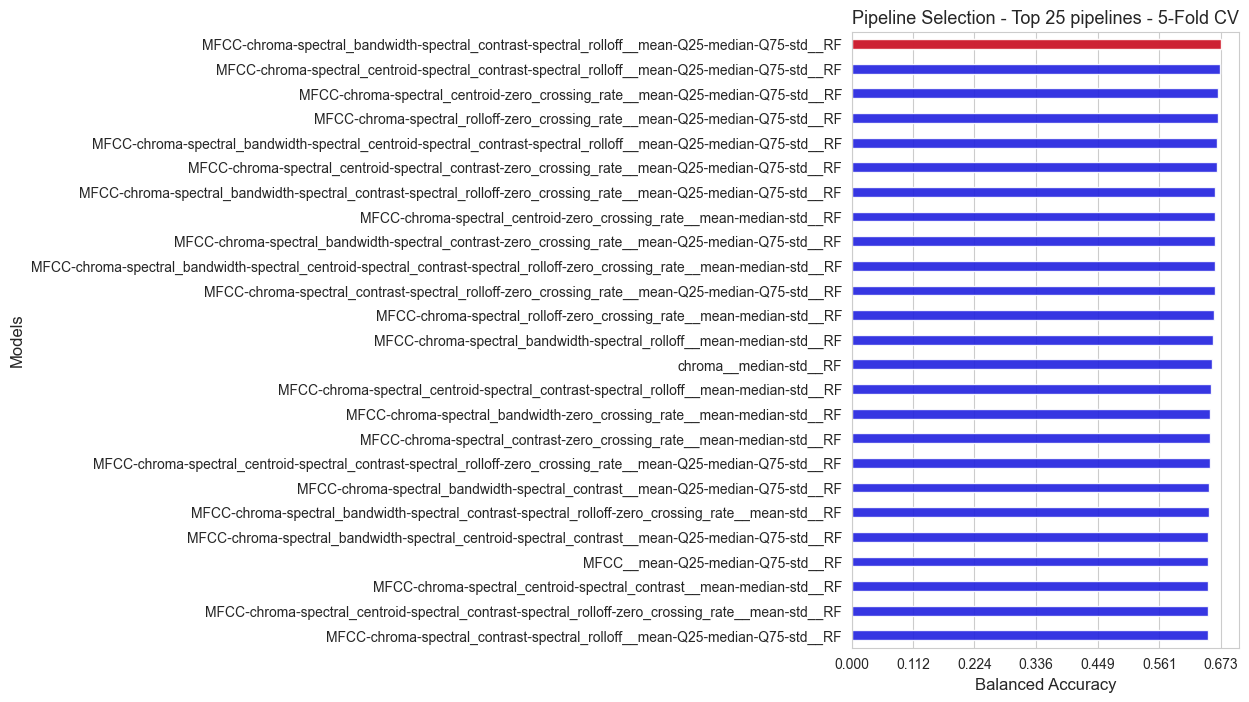

The best pipeline according to the inner evaluation is: MFCC-chroma-spectral_bandwidth-spectral_contrast-spectral_rolloff__mean-Q25-median-Q75-std__RF
Balanced accuracy of the best pipeline:  0.673

 Best feature extraction method:  MFCC-chroma-spectral_bandwidth-spectral_contrast-spectral_rolloff 
 Best stats:  mean-Q25-median-Q75-std 
 Best model:  RF

The best model hyper-parameters are:  {'n_estimators': 250, 'max_depth': 25, 'min_samples_split': 26, 'min_samples_leaf': 2, 'criterion': 'gini'}


In [25]:
n_top = 25

fig, axes = plt.subplots(figsize=(5,8))

ax = sns.barplot(y=sorted_pipelines[0:n_top], x=sorted_scores[0:n_top], color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('Balanced Accuracy', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Pipeline Selection - Top {n_top} pipelines - 5-Fold CV', size=13)
plt.show()

print(f'The best pipeline according to the inner evaluation is: {best_pipeline}')
print('Balanced accuracy of the best pipeline: ', np.round(score_best_pipeline, 3))
best_method = best_pipeline.split('__')[0]
best_stats = best_pipeline.split('__')[1]
best_model = best_pipeline.split('__')[2]
print('\n Best feature extraction method: ', best_method, '\n', 'Best stats: ', best_stats, '\n', 'Best model: ', best_model)

print('\nThe best model hyper-parameters are: ', best_params_flatten[best_pipeline])

We save the top 10 method-stats combinations, since they will be the considered combinations to be evaluated in the second round of the inner evaluation.

In [23]:
top_methods, top_stats = [], []
n_top = 10

for pipeline in sorted_pipelines[0:n_top]:
    top_methods.append(pipeline.split('__')[0])
    top_stats.append(pipeline.split('__')[1])

In [24]:
# Saving results 
'''
with open('results/top_methods_1', 'wb') as file:
    pickle.dump(top_methods, file)

with open('results/top_stats_1', 'wb') as file:
    pickle.dump(top_stats, file)
'''

"\nwith open('results/top_methods_1', 'wb') as file:\n    pickle.dump(top_methods, file)\n\nwith open('results/top_stats_1', 'wb') as file:\n    pickle.dump(top_stats, file)\n"